In [1]:
# from diffusers.utils import randn_tensor

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [3]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [4]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [5]:
from datasets import load_dataset

In [7]:
import pickle

In [8]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [9]:
with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
    idx_val = pickle.load(handle)
len(idx_val)

1000

In [1]:
from datasets import load_dataset

dataset = load_dataset(
    'cifar10',
    # args.dataset_config_name,
    # cache_dir=args.cache_dir,
    # split="train",
)

NameError: name 'load_dataset' is not defined

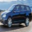

In [11]:
from datasets import DatasetDict, Dataset, load_dataset, Image

train_dataset = dataset['train'].select(idx_train)
train_dataset[0]["img"]

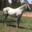

In [12]:
val_dataset =  dataset['test'].select(idx_val)
val_dataset[0]["img"]

In [13]:
idx_val[0:5]

[7405, 5226, 1363, 6615, 7612]

In [14]:
class Args():
            
    dataset_name="cifar10"

    output_dir="../../saved/5000-0.5/retrain"
    
    project_dim=65536

    used_dim=32768

    strategy='uniform'
    # strategy='cumulative'
   
args = Args()

In [15]:
import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_scheduler

In [16]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [17]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

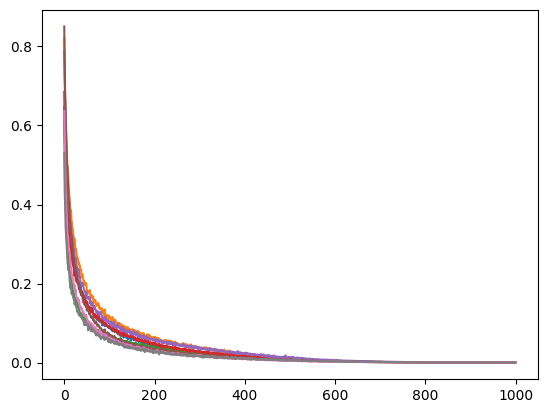

In [18]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [19]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [20]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

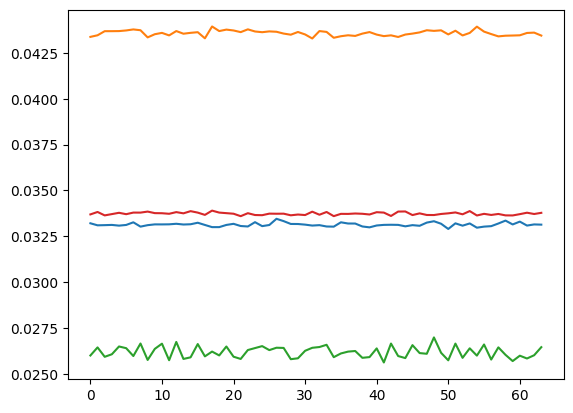

In [21]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [22]:
from scipy.stats import spearmanr, pearsonr
f_name_list = [
    'loss', 
    ####
    # 'mean',
    'mean-squared-l2-norm', 
    ####
    # 'l1_norm',
    # 'l2_norm',
    # 'linf_norm'
    ####
]

lamb_list = [

        1e-2, 2e-2, 5e-2,
        1e-1, 2e-1, 5e-1,
        1e0, 2e0, 5e0,
        1e1, 2e1, 5e1,
        1e2, 2e2, 5e2,
        1e3, 2e3, 5e3, 
        1e4, 2e4, 5e4, 
        1e5, 2e5, 5e5, 
        1e6, 2e6, 5e6, 
    ]

print(len(lamb_list))


ckpt_list = [
    0, 1, 
    2, 3, 4, 5, 6, 7,
            ]

27


In [23]:
# for loop over functions
seed_lds_list = []

seed_score_list = []

for num_seed in [
    1, 
    # 2, 3, 4, 5
]:
    print(num_seed)
    f_lds_list = []

    f_score_list = []
    
    for f in f_name_list:
        ####
        print(f)
        
        lds_list = []
        
        score_list = []
        
        K = 10
        for ckpt in ckpt_list:
            print(ckpt)
            ####
            dstore_keys_list = []
            for split in range(5):
                tmp = None
                for e_seed in range(num_seed):
                    dstore_keys = np.memmap('{}/ddpm-sub-{}-0/features-{}/ddpm-train-keys-{}-{}-{}-{}-{}.npy'.format(
                        args.output_dir, ckpt, e_seed,
                        split, K, args.project_dim, f, args.strategy), 
                                        dtype=np.float32, 
                                        mode='r',
                                        shape=(1000, args.project_dim))
                    dstore_keys = dstore_keys[:, :args.used_dim]
                    if e_seed==0:
                        tmp = dstore_keys.copy()
                    else:
                        tmp += dstore_keys
                tmp = tmp/num_seed
                dstore_keys_list.append(tmp) 
            
            dstore_keys = np.vstack(dstore_keys_list)
            print(dstore_keys.shape)  
            
            if f=='l1_norm':
                dstore_keys = dstore_keys / 3072
            elif f=='l2_norm':
                dstore_keys = dstore_keys / (3072**0.5)
            ####    
            tmp = None
            for e_seed in range(num_seed):
                gen_dstore_keys = np.memmap('{}/ddpm-sub-{}-0/features-{}/ddpm-val-keys-{}-{}-{}-{}-{}.npy'.format(
                       args.output_dir, ckpt, e_seed, 
                    0, K, args.project_dim, f, args.strategy), 
                                    dtype=np.float32, 
                                    mode='r',
                                    shape=(1000, args.project_dim))
                gen_dstore_keys = gen_dstore_keys[:, :args.used_dim]
                if e_seed==0:
                    tmp = gen_dstore_keys.copy()
                else:
                    tmp += gen_dstore_keys
            tmp = tmp/num_seed
            gen_dstore_keys = tmp
            print(gen_dstore_keys.shape)
            if f=='l1_norm':
                gen_dstore_keys = gen_dstore_keys / 3072
            elif f=='l2_norm':
                gen_dstore_keys = gen_dstore_keys / (3072**0.5)
            ####
            dstore_keys = torch.from_numpy(dstore_keys).cuda()
            gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()
            ####
            # if f=='l1_norm':
            #     dstore_keys = dstore_keys/3072
            #     gen_dstore_keys = gen_dstore_keys/3072
            ####
            kernel = dstore_keys.T@dstore_keys
            ####
            rs_list = []
            ps_list = []

            best_scores = None
            best_lds = -np.inf
            for lamb in lamb_list:
                print(lamb)
                # kernel_ = kernel + lamb*np.eye(kernel.shape[0])
                kernel_ = kernel + lamb*torch.eye(kernel.shape[0]).cuda()
                # kernel_ = torch.from_numpy(kernel_).cuda()
                ####
                kernel_ = torch.linalg.inv(kernel_)  
                # kernel_ = kernel_.cpu().numpy()
                ####
                print(kernel_.shape)
                print(torch.mean(kernel_.diagonal()))
                ####
                # scores = gen_dstore_keys.dot((dstore_keys@kernel_).T)
                scores = gen_dstore_keys@((dstore_keys@kernel_).T)
                print(scores.size())
                scores = scores.cpu().numpy()
    
                # compute lds
                margins = lds_testset_correctness
                infl_est_ = -scores
                preds = lds_mask_array @ infl_est_.T
                ####
                rs = []
                ps = []
    
                for ind in range(1000):
                   r, p = spearmanr(preds[:, ind], margins[:, ind])
                   # r, p = pearsonr(preds[:, ind], margins[:, ind])
                   rs.append(r)
                   ps.append(p)
        
                rs, ps = np.array(rs), np.array(ps)
                print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    
                rs_list.append(rs.mean())   
                ps_list.append(ps.mean())
                
                if rs.mean()>best_lds:
                    best_scores = scores
                    best_lds = rs.mean()
                    
            lds_list.append((rs_list, ps_list))
            score_list.append(best_scores)
            
        f_lds_list.append(lds_list)
        f_score_list.append(score_list)
    seed_lds_list.append(f_lds_list)
    seed_score_list.append(f_score_list)

1
loss
0
(5000, 32768)
(1000, 32768)
0.01
torch.Size([32768, 32768])
tensor(28.9364, device='cuda:0')
torch.Size([1000, 5000])
Correlation: -0.010 (avg p value 0.508424)
0.02
torch.Size([32768, 32768])
tensor(28.7215, device='cuda:0')
torch.Size([1000, 5000])
Correlation: -0.010 (avg p value 0.506979)
0.05
torch.Size([32768, 32768])
tensor(20.9553, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.060 (avg p value 0.472684)
0.1
torch.Size([32768, 32768])
tensor(8.7562, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.097 (avg p value 0.402503)
0.2
torch.Size([32768, 32768])
tensor(4.2710, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.097 (avg p value 0.404703)
0.5
torch.Size([32768, 32768])
tensor(1.6977, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.097 (avg p value 0.406824)
1.0
torch.Size([32768, 32768])
tensor(0.8483, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.096 (avg p value 0.406811)
2.0
torch.Size([32768, 32768])
tensor(0.4244,

In [24]:
seed_lds_array = np.array(seed_lds_list)
seed_lds_array[0]

array([[[[-1.03631478e-02, -9.56186204e-03,  5.99203670e-02,
           9.69904889e-02,  9.69172286e-02,  9.65299343e-02,
           9.64985696e-02,  9.65486610e-02,  9.72472874e-02,
           9.80465782e-02,  9.96633129e-02,  1.03480622e-01,
           1.08343168e-01,  1.13971259e-01,  1.21017620e-01,
           1.25994797e-01,  1.28403384e-01,  1.30249675e-01,
           1.30269295e-01,  1.28968149e-01,  1.22369797e-01,
           1.14955328e-01,  1.03879113e-01,  8.80881300e-02,
           7.80849685e-02,  7.09924516e-02,  6.53869802e-02],
         [ 5.08424033e-01,  5.06978667e-01,  4.72684112e-01,
           4.02502546e-01,  4.04702502e-01,  4.06823968e-01,
           4.06811422e-01,  4.06499583e-01,  4.05831879e-01,
           4.04250793e-01,  4.01970926e-01,  3.99556022e-01,
           3.94405056e-01,  3.90971149e-01,  3.80810543e-01,
           3.74844644e-01,  3.71515283e-01,  3.68955111e-01,
           3.66724142e-01,  3.70556934e-01,  3.82132360e-01,
           3.94336825e-

In [25]:
seed_lds_array.shape

(1, 2, 8, 2, 27)

In [26]:
K

10

In [27]:
with open('./val_5000_0.5_ckpt_{}.pkl'.format(K), 'wb') as handle:
    pickle.dump(seed_lds_array, handle)

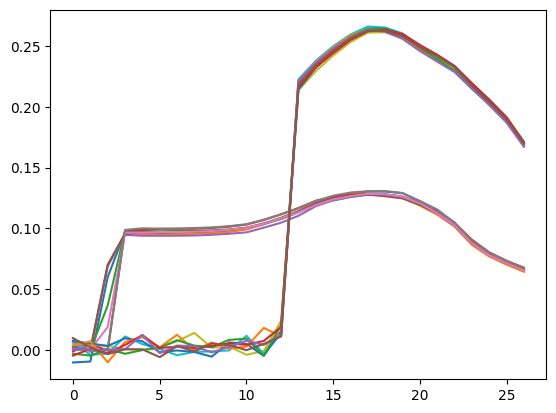

In [28]:
for i in range(1):
    for j in range(2):
        for k in range(seed_lds_array.shape[2]):
            plt.plot(seed_lds_array[i, j, k, 0])

In [29]:
seed_lds_array[:, :, :, 0].max(axis=-1)

array([[[0.13026929, 0.12874134, 0.12755132, 0.12819358, 0.12813763,
         0.12773882, 0.1283736 , 0.13074024],
        [0.26133412, 0.26613351, 0.26439266, 0.2641729 , 0.26424585,
         0.26337119, 0.26336814, 0.26265464]]])

In [30]:
seed_lds = seed_lds_array[:, :, :, 0].max(axis=-1)[:, :]
seed_lds.shape

(1, 2, 8)

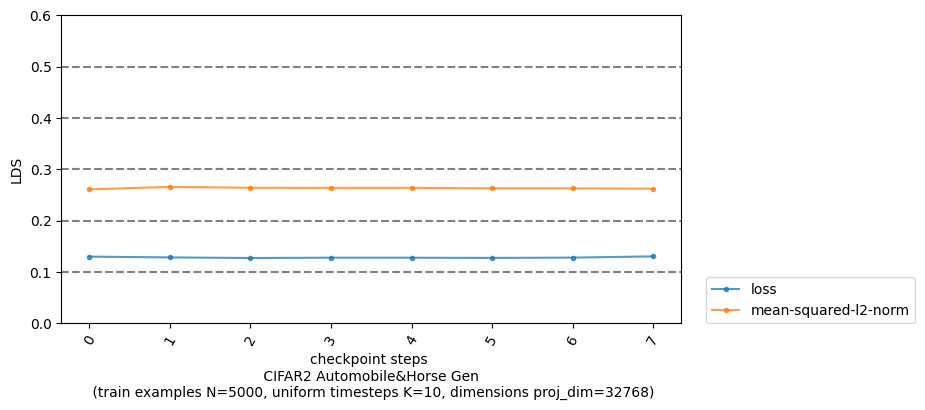

In [31]:
plt.figure(figsize=(8,4))

for idx, f in enumerate(f_name_list):
    plt.plot(ckpt_list, seed_lds[0, idx], label=f, marker='.', alpha=0.75)

plt.xlabel('checkpoint steps \n CIFAR2 Automobile&Horse Gen \n (train examples N=5000, uniform timesteps K=10, dimensions proj_dim=32768)')
plt.ylabel('LDS')
plt.xticks(ticks=ckpt_list, labels=ckpt_list, rotation=60)
plt.ylim(0, 0.6)

plt.axhline(y=0.5, color='gray', linestyle='dashed')
plt.axhline(y=0.4, color='gray', linestyle='dashed')
plt.axhline(y=0.3, color='gray', linestyle='dashed')
plt.axhline(y=0.2, color='gray', linestyle='dashed')
plt.axhline(y=0.1, color='gray', linestyle='dashed')

plt.legend(loc=(1.04, 0))

In [32]:
with open('./val_5000_0.5_scores_{}.pkl'.format(K), 'wb') as handle:
    pickle.dump(seed_score_list, handle)

In [33]:
len(seed_score_list)

1

In [34]:
len(seed_score_list[0])

2

In [35]:
len(seed_score_list[0][0])

8

In [36]:
seed_score_list[0][0][0].shape

(1000, 5000)

In [37]:
np.stack(seed_score_list[0][0]).mean(axis=0).shape

(1000, 5000)

In [38]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(seed_score_list[0][0])[0:8].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.135 (avg p value 0.354702)


In [39]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(seed_score_list[0][1])[0:8].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.285 (avg p value 0.134676)
